In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
noise_factor = 0.4
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [4]:
def build_autoencoder():
    input_img = layers.Input(shape=(28, 28, 1))

    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)  # (7, 7, 64)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = models.Model(input_img, decoded)
    encoder = models.Model(input_img, encoded)

    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder, encoder

autoencoder, encoder = build_autoencoder()

In [5]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [6]:
history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test),
    callbacks=[early_stop]
)


Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.3602 - val_loss: 0.2990
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2949 - val_loss: 0.2930
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.2903 - val_loss: 0.2895
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.2867 - val_loss: 0.2871
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.2841 - val_loss: 0.2853
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2833 - val_loss: 0.2844
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.2815 - val_loss: 0.2837
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.2801 - val_loss: 0.2828
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.2804 - val_loss: 0.2823
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.2803 - val_loss: 0.2818
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.2796 - val_loss: 0.2820
Epoch 12/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/st

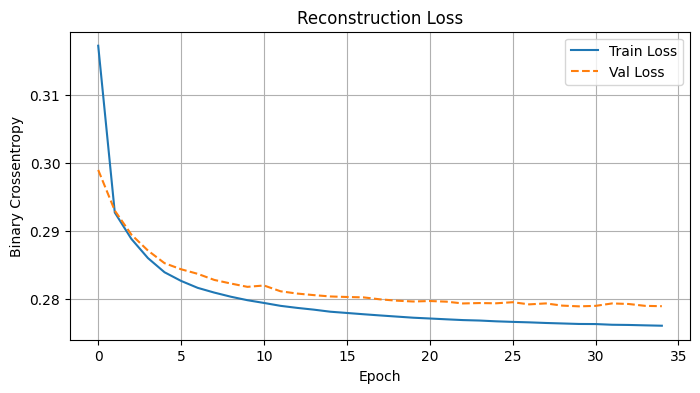

In [7]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss', linestyle='--')
plt.title('Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy')
plt.legend()
plt.grid(True)
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


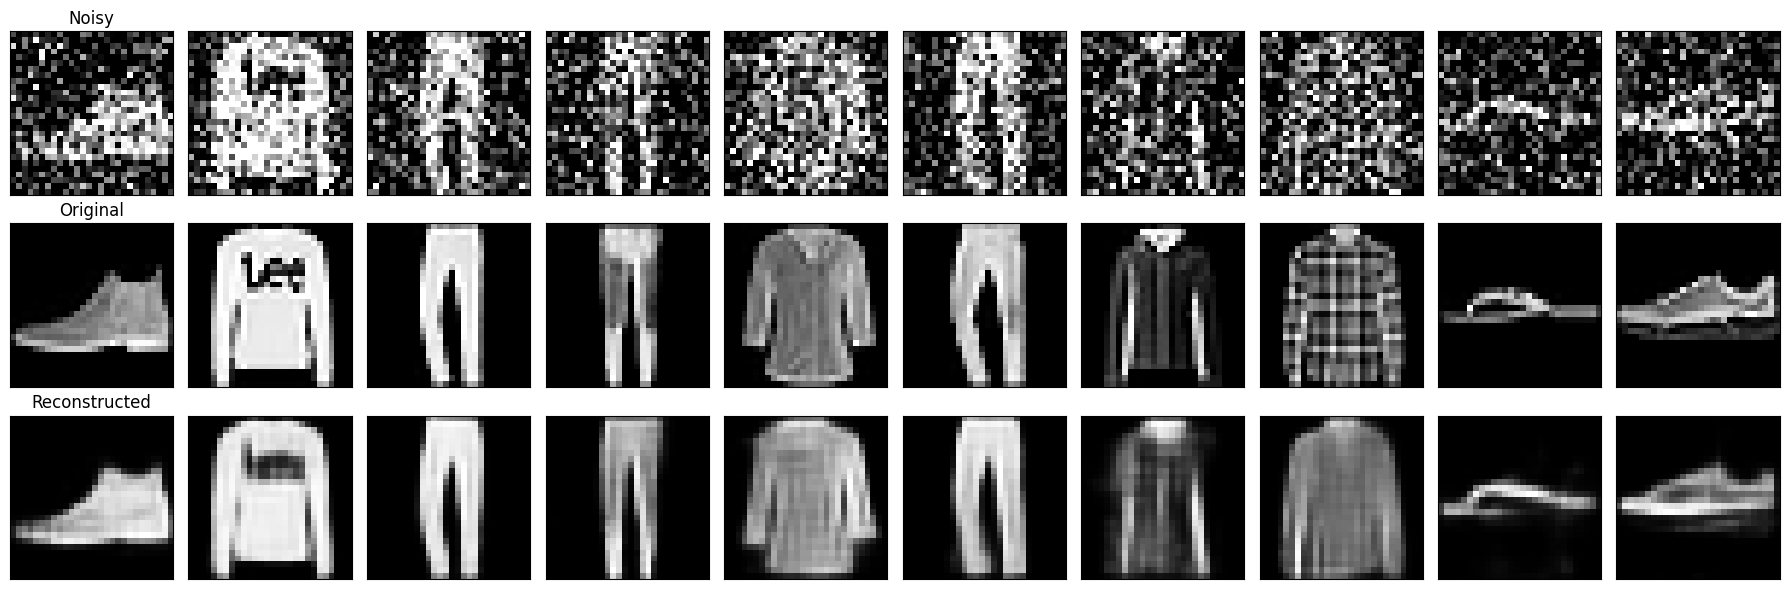

In [8]:
decoded_imgs = autoencoder.predict(x_test_noisy)
n = 10
plt.figure(figsize=(18, 6))
for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0: ax.set_title("Noisy")

    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0: ax.set_title("Original")

    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0: ax.set_title("Reconstructed")

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


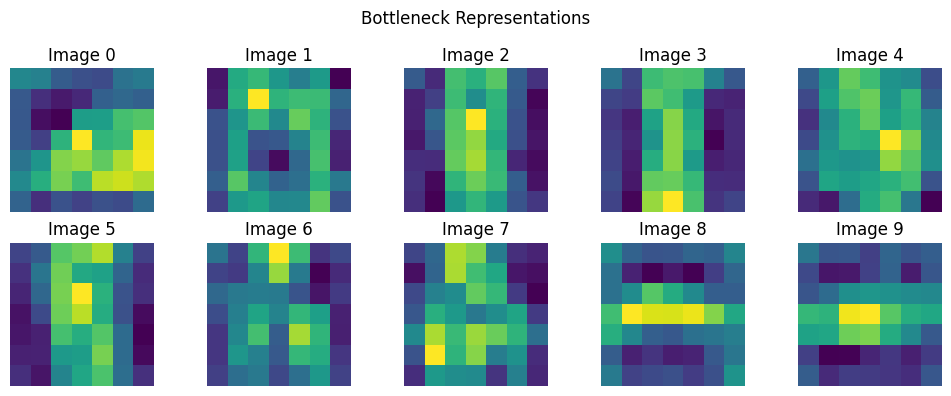

In [9]:
encoded_imgs = encoder.predict(x_test_noisy[:10])
plt.figure(figsize=(10, 4))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    encoded_flat = np.mean(encoded_imgs[i], axis=-1)
    plt.imshow(encoded_flat, cmap='viridis')
    ax.set_title(f'Image {i}')
    ax.axis('off')
plt.suptitle('Bottleneck Representations')
plt.tight_layout()
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


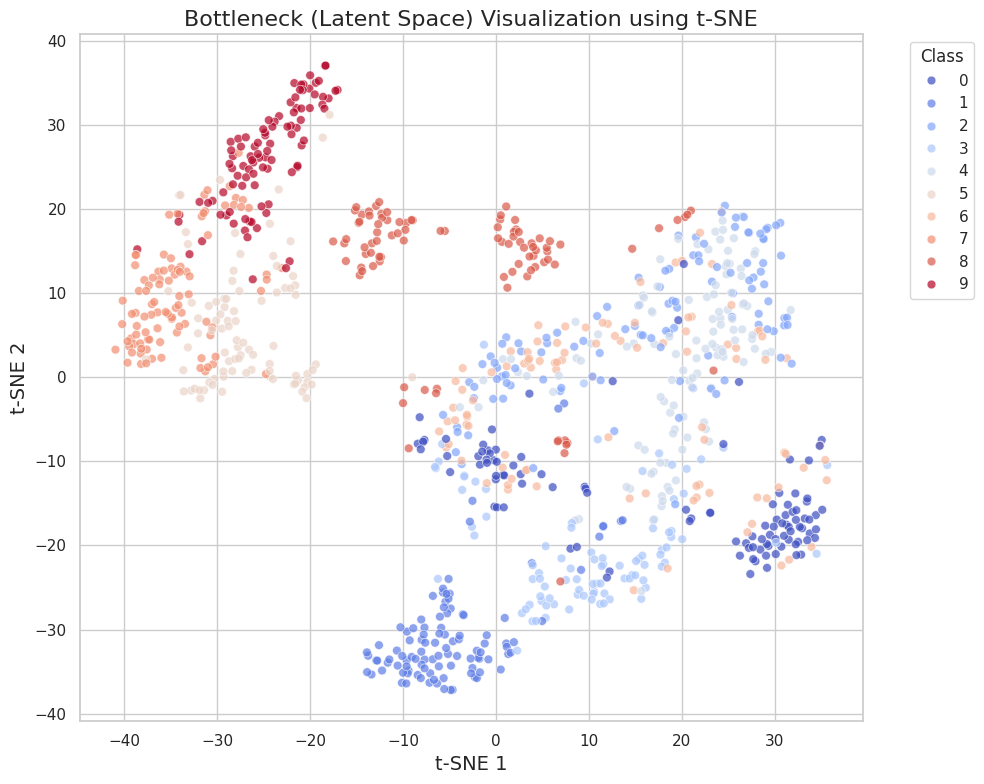

In [10]:
from keras.datasets import fashion_mnist
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

(_, y_train), (_, y_test) = fashion_mnist.load_data()

encoded_imgs = encoder.predict(x_test[:1000])

encoded_flat = encoded_imgs.reshape(1000, -1)

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(encoded_flat)

sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=tsne_result[:, 0], y=tsne_result[:, 1],
    hue=y_test[:1000],
    palette='coolwarm', legend='full',
    s=40, alpha=0.7
)
plt.title('Bottleneck (Latent Space) Visualization using t-SNE', fontsize=16)
plt.xlabel('t-SNE 1', fontsize=14)
plt.ylabel('t-SNE 2', fontsize=14)
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Summary & Insights

In this project, we built a convolutional denoising autoencoder to clean up noisy Fashion MNIST images. The goal was to teach a model to recover the original image from its noisy version

Objective: Remove noise from images using deep learning.

Denoising helps models learn cleaner, more generalizable features.

Training: Loss dropped smoothly for both training and validation — no overfitting.

Results: Reconstructed images retained important visual details.

Latent Space: t-SNE showed nice clusters, suggesting the model learned meaningful features.

Transferable Features: The encoded data could be reused for tasks like classification or anomaly detection.